Word Frequency method for scoring - only on testing as there is no model behind it that needs to be trained

# Libraries

In [18]:
!pip install rouge_score
!pip install evaluate
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:


from string import punctuation

import pandas as pd
import numpy as np
from tqdm import tqdm


from datasets import list_datasets, load_dataset


In [21]:
# nltk.download('punkt')
# nltk.download('stopwords')

# Data

Due to time it takes, tensorflow data was downloaded and saved as csv for iteration process to take less time

In [22]:
ds = load_dataset('mlsum', 'es')
df = pd.DataFrame(ds["test"])
df_validation = pd.DataFrame(ds["validation"])
df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

(13920, 6)

In [23]:
df.head()


,text,summary,topic,url,title,date
0,"Despedida de Rajoy, tras perder la votación de...","Doce meses después de la moción de censura, su...",politica actualidad,http://elpais.com/politica/2019/05/31/actualid...,Un año de la carambola que lo cambió todo,01/06/2019
1,Si no puede ver la retransmisión del desfile e...,Los Reyes presiden este sábado el desfile de l...,politica actualidad,http://elpais.com/politica/2019/05/31/actualid...,Día de las Fuerzas Armadas: Sevilla homenajea ...,01/06/2019
2,Cocina como si danzara. Da pasos grandes y más...,La tradicional receta de Senegal se creó en la...,elpais planeta_futuro,http://elpais.com/elpais/2019/03/26/planeta_fu...,"‘Ceebu jën’, el plato de los cuatro continentes",01/06/2019
3,Una escena de la película 'RocketMan'. En víde...,‘Bohemian Rhapsody’ y ‘Rocketman’ prefiguran o...,elpais gente,http://elpais.com/elpais/2019/05/31/gente/1559...,"Si cantas y no tienes ‘biopic’, no eres nadie",01/06/2019
4,"Impecable en estilo y formas, Amadou Diaw (Dak...",Amadou Diaw es una persona clave en el desarro...,elpais planeta_futuro,http://elpais.com/elpais/2019/05/28/planeta_fu...,“En África sopla un nuevo viento: las mujeres ...,01/06/2019


## EDA

In [24]:
df["words_text"] = df["text"].apply(lambda n: len(n.split()))
df["words_summary"] = df["summary"].apply(lambda n: len(n.split()))
df["summary_perc"] = df["words_summary"]/df["words_text"] 
df.describe()

,words_text,words_summary,summary_perc
count,13920.00000,13920.000000,13920.000000
mean,783.92579,21.919828,0.045668
std,573.95292,7.326019,0.063677
min,50.00000,10.000000,0.001428
25%,479.00000,17.000000,0.021452
50%,704.00000,21.000000,0.029940
75%,965.25000,26.000000,0.044843
max,14004.00000,89.000000,0.926471


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80c3257f40>,
      dtype=object)

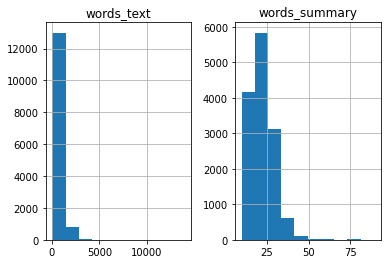

In [25]:
df[["words_text", "words_summary"]].hist()

In [26]:

from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
stop_words = set(stopwords.words('spanish'))

def word_freq_summary_p1(data):
  # Tokenizer and loweer case
  tokens_df =pd.DataFrame(data["text"].str.lower().map(word_tokenize)).rename(columns={"text":"words"})
  tokens_df["sentences"] =data["text"].str.lower().map(sent_tokenize)
  tokens_df["sentences"] = tokens_df["sentences"]
  # Remove stopwords and punctuation
  tokens_df["words"] = tokens_df["words"].apply(lambda word_tokens: [w for w in word_tokens if (not w in stop_words) & (not w in string.punctuation)])
  # Frequency
  tokens_df["freq_words"] = tokens_df["words"].apply(Counter)
  tokens_df["max_freq"] = tokens_df["freq_words"].apply(lambda x: max(x.values()))
  # Normalize
  tokens_df["freq_words"] = tokens_df["freq_words"].apply(lambda x: {key: value / max(x.values()) for key, value in x.items()})

  # Sum at sentence level 
  tokens_df["sentence_score"] = ""

  for i in range(tokens_df.shape[0]):
    sentence_score = []
    for sentence in tokens_df["sentences"][i]:
      sentence_score_temp = 0
      for word in word_tokenize(sentence): 
        if word in tokens_df["freq_words"][i].keys():
          sentence_score_temp += tokens_df["freq_words"][i][word]
      sentence_score.append(sentence_score_temp)
    tokens_df["sentence_score"][i] = sentence_score
  return tokens_df

def word_freq_summary_p2(tokens_df, per):
  # Get length 
  tokens_df["len"] = tokens_df["sentences"].apply(lambda x: int(len(x)*per))


  # Extract only the sentence that pass the threshold
  summary = []
  for row in tqdm(range(tokens_df.shape[0])):
    sentence_index = sorted(range(len(tokens_df["sentence_score"][row])), key=lambda i: tokens_df["sentence_score"][row][i])[-tokens_df["len"][row]:]
    temp_summary = [tokens_df["sentences"][row][id] for id in sentence_index] 
    temp_summary = ''.join(temp_summary)
    summary.append(temp_summary)
  tokens_df["summary"] = summary
  return tokens_df

# Hyperparameter tuning

In [27]:
threshold_l = [0.025, 0.05, 0.08 ,0.1]
y_validation = df_validation["summary"]
df_validation_p = word_freq_summary_p1(df_validation)
# Select best threshold
list_rouge = []
import evaluate
for threshold in tqdm(threshold_l):
  df_validation_temp = word_freq_summary_p2(df_validation_p, threshold)
  y_pred = df_validation_temp["summary"]
  rouge_score = evaluate.load("rouge")
  dic_temp = rouge_score.compute(predictions=y_pred, references=y_validation)
  list_rouge.append(dic_temp)

print(list_rouge)

<ipython-input-26-a18e5a177c11>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_df["sentence_score"][i] = sentence_score
100%|██████████| 4/4 [05:18<00:00, 79.54s/it]

[{'rouge1': 0.10240969487055897, 'rouge2': 0.04074597606977763, 'rougeL': 0.07787250728371652, 'rougeLsum': 0.07787359338620177}, {'rouge1': 0.15864003287891829, 'rouge2': 0.04626324982430123, 'rougeL': 0.1154120136554713, 'rougeLsum': 0.11539655414957922}, {'rouge1': 0.16478433830550293, 'rouge2': 0.04709755987657341, 'rougeL': 0.11965905746035371, 'rougeLsum': 0.11961656246921257}, {'rouge1': 0.15964446037262187, 'rouge2': 0.047823571717918234, 'rougeL': 0.11664542568076812, 'rougeLsum': 0.11660369562996867}]


In [28]:
y_pred#.shape

0        no se recomienda administrar a menores de cuat...
1        la primera cristina pedroche, que apareció en ...
2        la mujer ha sufrido un traumatismo craneoencef...
3        gracias.(foto: ap, ronald zak)ha sido un place...
4        tres horas antes de que sonaran las campanadas...
                               ...                        
10353    compra por 64,99€ (10% menos con el cupón porq...
10354    el presidente de banc sabadell, josep oliu, la...
10355    up to 25 years the public prosecution is uphol...
10356    se llaman derby motoreta’s burrito kachimba, c...
10357    por su parte, valls ha asegurado este jueves q...
Name: summary, Length: 10358, dtype: object

In [29]:
f1 = [d['rougeL'] for d in list_rouge]
print(f1)
per_max = threshold_l[np.argmax(f1)]
print("threshold:", per_max)

[0.07787250728371652, 0.1154120136554713, 0.11965905746035371, 0.11664542568076812]
threshold: 0.08


# Performance metrics

In [30]:
y_test = df["summary"]
df_p = word_freq_summary_p1(df)
df = word_freq_summary_p2(df_p, per_max)


<ipython-input-26-a18e5a177c11>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_df["sentence_score"][i] = sentence_score
100%|██████████| 13920/13920 [00:03<00:00, 3839.63it/s]


In [31]:
#y_test = df["summary"]
y_pred = df["summary"]

In [32]:
import evaluate
rouge_score = evaluate.load("rouge")
rouge_score.compute(predictions=y_pred, references=y_test)



{'rouge1': 0.16341412598207156,
 'rouge2': 0.04716274196715148,
 'rougeL': 0.1183617673861291,
 'rougeLsum': 0.11833996543338623}

In [35]:
y_test[1]

'Los Reyes presiden este sábado el desfile de las Fuerzas Armadas'

In [36]:
y_pred[1]

'un total de 245 familiares de los militares que han perdido la vida en estos años —entre ellos, los 62 fallecidos en el accidente del yak-42, la mayor catástrofe de las fuerzas armadas en tiempos de paz— estarán presentes en la exhibición, en la que participarán 84 aeronaves, 200 vehículos terrestres y 2.600 militares de los tres ejércitos y la guardia civil.'